In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from datetime import timedelta
import matplotlib.pyplot as plt

# --------------------------
# CONFIGURATION
# --------------------------

GROUNDWATER_PATH = '../data/wasserportal/processed/gw_data_2022-01-01_2025-04-30.parquet'
STATIONS_PATH = '../data/wasserportal/stations_groundwater.csv'
PRECIP_ZARR_PATH = '../data/dwd/processed/radolan_berlin_2022-01-01_2025-04-30.zarr'

STATION_ID = '9931'  # Change to your target station
STATION_ID = '100'
N_GW_LAGS = 4
N_PRCP_LAGS = 4
INCLUDE_PRCP_T_PLUS_1 = True
SEASONALITY = True
PREDICTION_HORIZON = 7  # Predict next 7 days


# Data Loading and Preprocessing

In this section, we'll load the required datasets for groundwater level prediction:
1. **Groundwater levels**: Historical measurements from monitoring stations
2. **Precipitation data**: Radar-based precipitation data from DWD (German Weather Service)
3. **Station metadata**: Geographic coordinates and station information

Our goal is to predict groundwater levels for the **next 7 days** using historical groundwater data and precipitation patterns with a **single multi-output model**.

In [ ]:
# --------------------------
# LOAD DATA
# --------------------------

# Groundwater levels
gw_df = pd.read_parquet(GROUNDWATER_PATH)
gw_series = gw_df[f"value_{STATION_ID}"].dropna()
gw_series.index = pd.to_datetime(gw_series.index)

# Timestamps
dates = gw_series.index

# Load precipitation from zarr
import xarray as xr

precip_ds = xr.open_zarr(PRECIP_ZARR_PATH)
precip_array = precip_ds['precipitation'].values  # shape: (time, 30, 30)

# Load coordinates
lats = precip_ds['lat'].values
lons = precip_ds['lon'].values

# Load station metadata
stations_df = pd.read_csv(STATIONS_PATH)
station = stations_df[stations_df['ID'] == int(STATION_ID)].iloc[0]

# --------------------------
# HELPER: Get grid cell
# --------------------------


def get_closest_grid_cell(lat, lon, lat_grid, lon_grid):
    dist = np.sqrt((lat_grid - lat)**2 + (lon_grid - lon)**2)
    idx = np.unravel_index(np.argmin(dist), dist.shape)
    return idx


grid_row, grid_col = get_closest_grid_cell(station['lat'], station['lon'],
                                           lats, lons)
precip_series = pd.Series(precip_array[:, grid_row, grid_col],
                          index=pd.to_datetime(precip_ds['time'].values))

In [ ]:
# from statsmodels.tsa.stattools import grangercausalitytests

# max_lag = 14  # try 2 weeks

# # Align both series to daily frequency
# gw_daily = gw_series.resample('D').mean()
# precip_daily = precip_series.resample('D').mean()

# # Combine and drop missing values
# data = pd.concat([gw_daily, precip_daily], axis=1).dropna()
# data.columns = ['gw', 'precip']

# # Check if enough observations for max_lag
# if len(data) > max_lag + 1:
#     grangercausalitytests(data[['gw', 'precip']], maxlag=max_lag)
# else:
#     print(
#         f"Not enough data for max_lag={max_lag}. Available rows: {len(data)}")


Dataset shape: X=(1201, 7), y=(1201, 7)
Training multi-output XGBoost model...

MULTI-OUTPUT PREDICTION RESULTS
   day_1: RMSE=0.028, MAE=0.021, R2=0.481
   day_2: RMSE=0.029, MAE=0.022, R2=0.444
   day_3: RMSE=0.033, MAE=0.025, R2=0.281
   day_4: RMSE=0.036, MAE=0.027, R2=0.146
   day_5: RMSE=0.036, MAE=0.028, R2=0.159
   day_6: RMSE=0.038, MAE=0.029, R2=0.024
   day_7: RMSE=0.041, MAE=0.032, R2=-0.100

MULTI-OUTPUT PREDICTION RESULTS
   day_1: RMSE=0.028, MAE=0.021, R2=0.481
   day_2: RMSE=0.029, MAE=0.022, R2=0.444
   day_3: RMSE=0.033, MAE=0.025, R2=0.281
   day_4: RMSE=0.036, MAE=0.027, R2=0.146
   day_5: RMSE=0.036, MAE=0.028, R2=0.159
   day_6: RMSE=0.038, MAE=0.029, R2=0.024
   day_7: RMSE=0.041, MAE=0.032, R2=-0.100


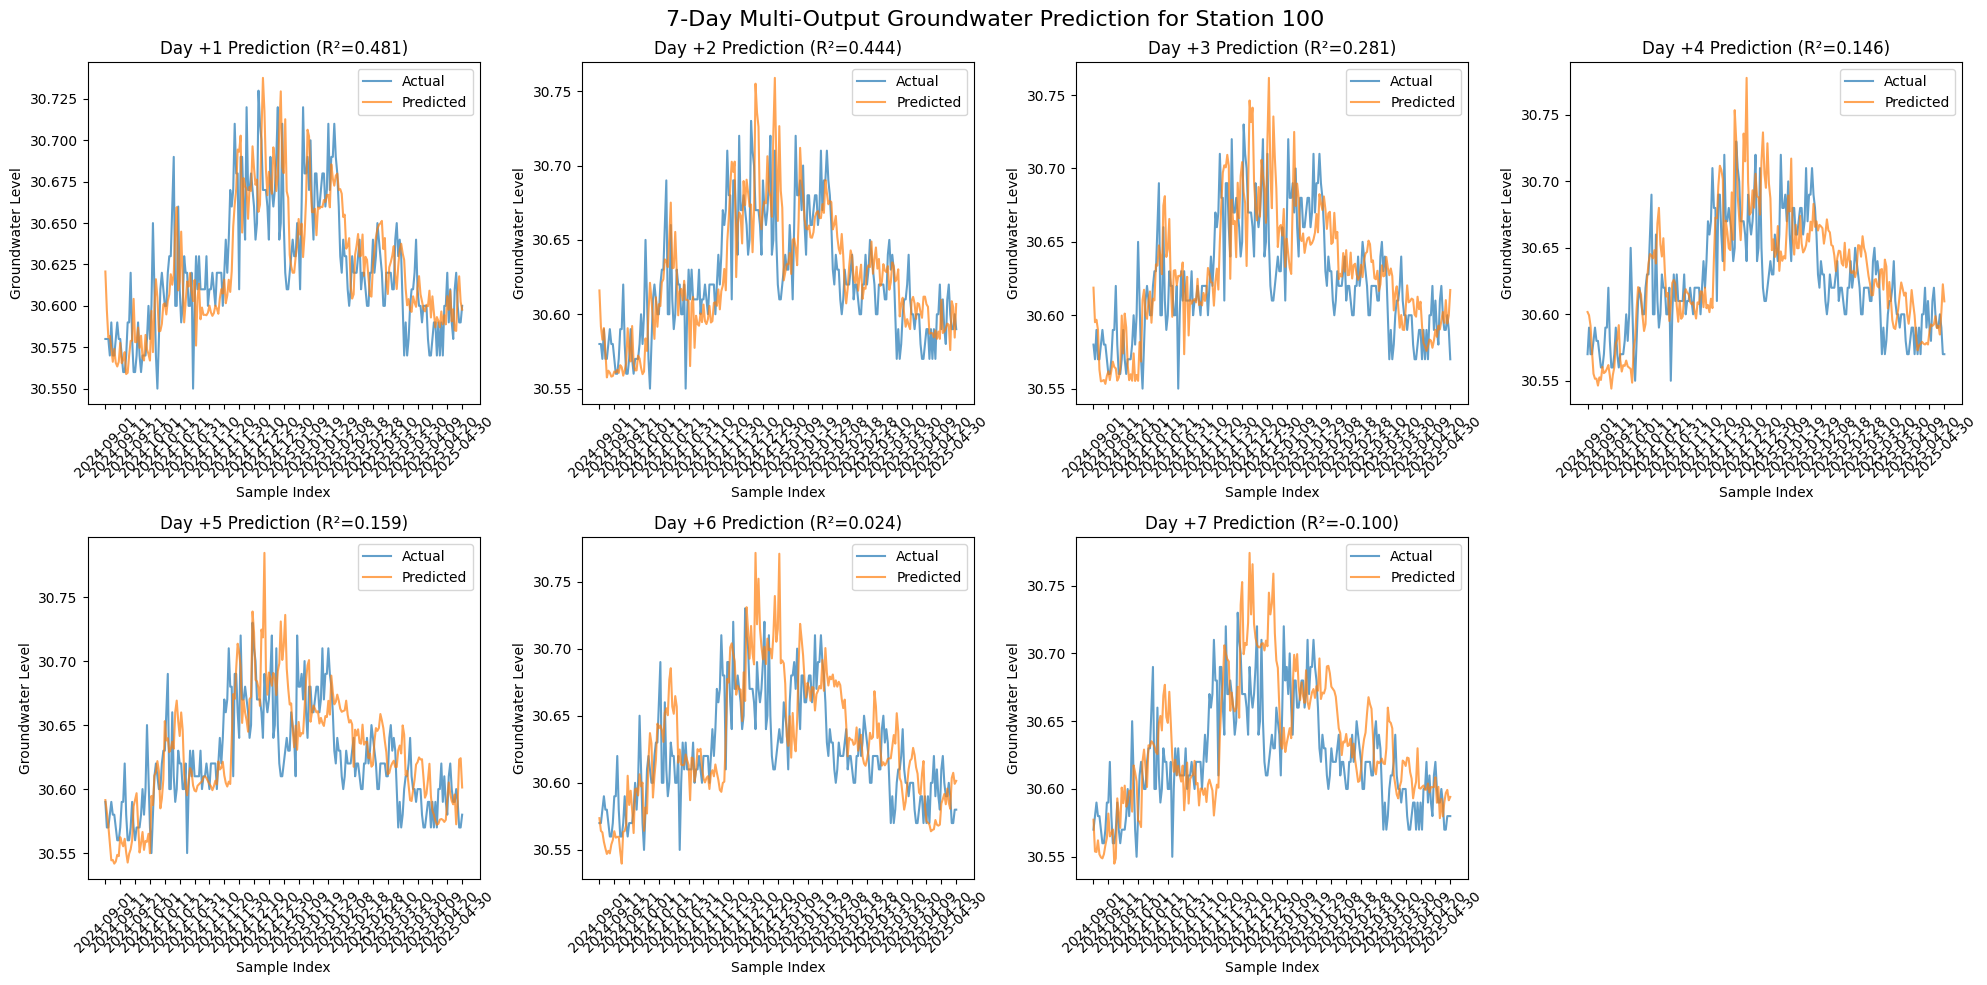


Feature Importance (averaged across all outputs):
gw_lag_1: 0.0933
gw_lag_2: 0.0252
gw_lag_3: 0.0122
gw_lag_4: 0.0023
month: 0.0020
prcp_sum_14: 0.0016
prcp_sum_30: 0.0013

Prediction Quality Degradation:
------------------------------
Day +1: R² = 0.481 (baseline)
Day +2: R² = 0.444 (↓0.036)
Day +3: R² = 0.281 (↓0.199)
Day +4: R² = 0.146 (↓0.335)
Day +5: R² = 0.159 (↓0.322)
Day +6: R² = 0.024 (↓0.456)
Day +7: R² = -0.100 (↓0.581)


In [ ]:
# --------------------------
# BUILD SUPERVISED DATASET FOR MULTI-OUTPUT PREDICTION
# --------------------------

feature_rows = []
target_rows = []

# Precompute daily precipitation for fast access
precip_df = precip_series.copy()
precip_df.index = pd.to_datetime(precip_df.index)
precip_df = precip_df.sort_index()

# Create rolling sums
precip_rolled_14 = precip_df.rolling(window=14).sum()
precip_rolled_30 = precip_df.rolling(window=30).sum()

for t in range(N_GW_LAGS, len(gw_series) - PREDICTION_HORIZON):

    date = gw_series.index[t]

    # Fetch rolling sums
    try:
        prcp_sum_14 = precip_rolled_14.loc[precip_rolled_14.index.date ==
                                           date.date()].values[0]
        prcp_sum_30 = precip_rolled_30.loc[precip_rolled_30.index.date ==
                                           date.date()].values[0]
    except (KeyError, IndexError):
        continue  # skip if data is missing

    # Groundwater lags
    gw_window = gw_series.iloc[t - N_GW_LAGS:t].values

    # Date-based features
    row = list(gw_window) + [prcp_sum_14, prcp_sum_30]
    if SEASONALITY:
        dayofyear = date.dayofyear
        row += [
            date.month,
        ]

    # Create target vector for next 7 days
    target_vector = []
    valid_targets = True

    for day in range(1, PREDICTION_HORIZON + 1):
        if t + day < len(gw_series):
            target_val = gw_series.iloc[t + day]
            if pd.notnull(target_val):
                target_vector.append(target_val)
            else:
                valid_targets = False
                break
        else:
            valid_targets = False
            break

    if valid_targets and len(target_vector) == PREDICTION_HORIZON:
        feature_rows.append(row)
        target_rows.append(target_vector)

# --------------------------
# TO DATAFRAME AND ARRAYS
# --------------------------

X = pd.DataFrame(feature_rows)
y = np.array(target_rows)  # Shape: (n_samples, 7)

# Optional: name columns
X.columns = ([f'gw_lag_{i}' for i in reversed(range(1, N_GW_LAGS + 1))] +
             ['prcp_sum_14', 'prcp_sum_30'] + ['month'])

print(f"Dataset shape: X={X.shape}, y={y.shape}")

# --------------------------
# SPLIT + TRAIN MULTI-OUTPUT MODEL
# --------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    shuffle=False  # no shuffle for time series!
)

print("Training multi-output XGBoost model...")

# Create multi-output regressor
base_model = xgb.XGBRegressor(n_estimators=200,
                              max_depth=5,
                              learning_rate=0.05,
                              subsample=0.8,
                              colsample_bytree=0.8,
                              random_state=42)

model = MultiOutputRegressor(base_model)
model.fit(X_train, y_train)

# --------------------------
# PREDICT AND EVALUATE
# --------------------------

y_pred = model.predict(X_test)

# Calculate metrics for each prediction day
metrics = {}
predictions = {}

print("\n" + "=" * 50)
print("MULTI-OUTPUT PREDICTION RESULTS")
print("=" * 50)

for day in range(PREDICTION_HORIZON):
    day_key = f'day_{day+1}'

    y_test_day = y_test[:, day]
    y_pred_day = y_pred[:, day]

    predictions[day_key] = y_pred_day

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test_day, y_pred_day))
    mae = mean_absolute_error(y_test_day, y_pred_day)
    r2 = r2_score(y_test_day, y_pred_day)

    metrics[day_key] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}

    print(f"{day_key:>8}: RMSE={rmse:.3f}, MAE={mae:.3f}, R2={r2:.3f}")

# --------------------------
# PLOT RESULTS
# --------------------------

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

# Create index for test data (approximate, since we don't have exact dates)
test_indices = range(len(y_test))

for day in range(PREDICTION_HORIZON):
    day_key = f'day_{day+1}'
    ax = axes[day]

    y_test_day = y_test[:, day]
    y_pred_day = predictions[day_key]

    ax.plot(test_indices, y_test_day, label='Actual', alpha=0.7)
    ax.plot(test_indices, y_pred_day, label='Predicted', alpha=0.7)
    ax.set_title(f'Day +{day+1} Prediction (R²={metrics[day_key]["R2"]:.3f})')
    ax.legend()
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Groundwater Level')

    xticks = list(range(0, len(y_test), 10))
    ax.set_xticks(xticks)
    ax.set_xticklabels(
        [gw_series.index[-len(y_test):][i].date() for i in xticks],
        rotation=45)

# Hide the last subplot if we have 7 days
if PREDICTION_HORIZON == 7:
    axes[7].set_visible(False)

plt.suptitle(
    f'7-Day Multi-Output Groundwater Prediction for Station {STATION_ID}',
    fontsize=16)
plt.tight_layout()
plt.show()

# --------------------------
# FEATURE IMPORTANCE
# --------------------------

print("\nFeature Importance (averaged across all outputs):")

# Get feature importance from the first estimator (they should be similar)
importance_scores = model.estimators_[0].get_booster().get_score(
    importance_type='gain')

for feature, score in sorted(importance_scores.items(),
                             key=lambda x: x[1],
                             reverse=True):
    print(f"{feature}: {score:.4f}")

# --------------------------
# PREDICTION DEGRADATION ANALYSIS
# --------------------------

print("\nPrediction Quality Degradation:")
print("-" * 30)
r2_values = [metrics[f'day_{i+1}']['R2'] for i in range(PREDICTION_HORIZON)]
for i, r2 in enumerate(r2_values):
    if i == 0:
        print(f"Day +{i+1}: R² = {r2:.3f} (baseline)")
    else:
        degradation = r2_values[0] - r2
        print(f"Day +{i+1}: R² = {r2:.3f} (↓{degradation:.3f})")
